<a href="https://colab.research.google.com/github/yashromakarona/myCodePractice/blob/main/dl__05_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import numpy as np
import os
os.makedirs("./data/gan_images", exist_ok=True)

In [21]:
def gan_train(epoch, batch_size, save_interval):

  (X_train, _), (_, _) = mnist.load_data()
  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype("float32")
  X_train = (X_train - 127.5) / 127.5

  true = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for i in range(epoch):
    discriminator.trainable = True

    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]
    d_loss_real = discriminator.train_on_batch(imgs, true)

    noise = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(noise,verbose=0)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    discriminator.trainable = False

    noise = np.random.normal(0, 1, (batch_size, 100))
    g_loss = gan.train_on_batch(noise, true)

    if i % 100 == 0:
      print('epoch:%d'%i, 'd_loss:%.4f'%d_loss[0], 'g_loss:%.4f'%g_loss)

      if i % save_interval == 0:
        noise = np.random.normal(0, 1, (25, 100))
        gen_imgs = generator.predict(noise, verbose=0)

        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(5, 5)
        count = 0
        for j in range(5):
          for k in range(5):
            axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
            axs[j, k].axis('off')
            count += 1
        fig.savefig("./data/gan_images/gan_mnist_%d.png"%i)

In [13]:
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation="relu"))
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=5, padding="same"))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding="same", activation="tanh"))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))
discriminator.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
discriminator.trainable = False

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
ginput = Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
gan.summary()

Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 28, 28, 1)      │       865,281 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 1)              │       212,865 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,078,146 (4.11 MB)

 Trainable params: 852,609 (3.25 MB)

 Non-trainable params: 225,537 (881.00 KB)

epoch:0 d_loss:0.6215 g_loss:0.6832
epoch:100 d_loss:0.3425 g_loss:0.3437
epoch:200 d_loss:0.3600 g_loss:0.4154
epoch:300 d_loss:0.4811 g_loss:0.5698
epoch:400 d_loss:0.5544 g_loss:0.6372
epoch:500 d_loss:0.5937 g_loss:0.6668
epoch:600 d_loss:0.6143 g_loss:0.6843
epoch:700 d_loss:0.6262 g_loss:0.6975
epoch:800 d_loss:0.6344 g_loss:0.7062
epoch:900 d_loss:0.6407 g_loss:0.7123
epoch:1000 d_loss:0.6453 g_loss:0.7171
epoch:1100 d_loss:0.6486 g_loss:0.7214
epoch:1200 d_loss:0.6510 g_loss:0.7257
epoch:1300 d_loss:0.6529 g_loss:0.7296
epoch:1400 d_loss:0.6548 g_loss:0.7331
epoch:1500 d_loss:0.6563 g_loss:0.7358
epoch:1600 d_loss:0.6580 g_loss:0.7384
epoch:1700 d_loss:0.6596 g_loss:0.7401
epoch:1800 d_loss:0.6609 g_loss:0.7418
epoch:1900 d_loss:0.6621 g_loss:0.7434
epoch:2000 d_loss:0.6633 g_loss:0.7442
epoch:2100 d_loss:0.6642 g_loss:0.7451
epoch:2200 d_loss:0.6649 g_loss:0.7458
epoch:2300 d_loss:0.6657 g_loss:0.7465
epoch:2400 d_loss:0.6661 g_loss:0.7474
epoch:2500 d_loss:0.6667 g_loss:0.748

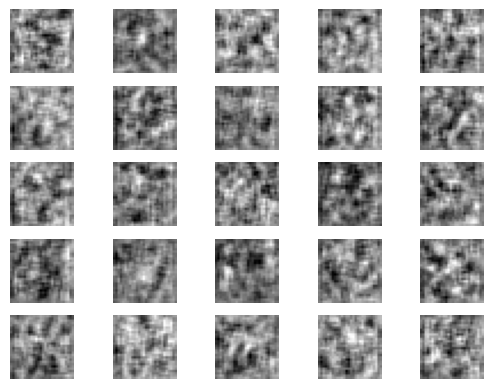

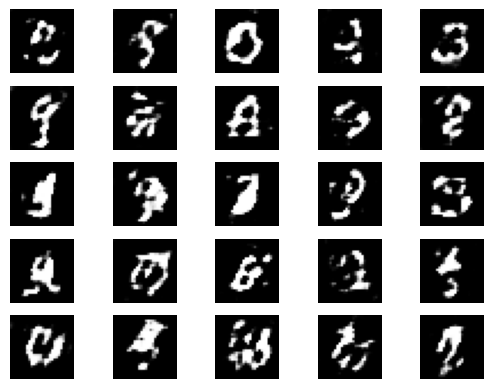

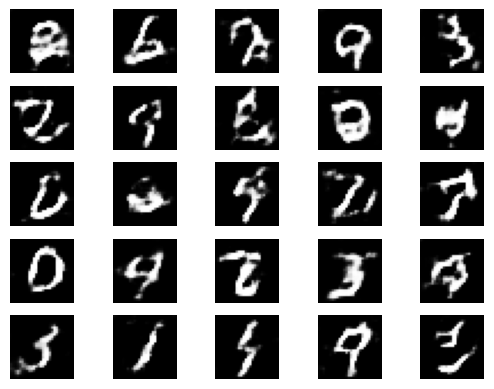

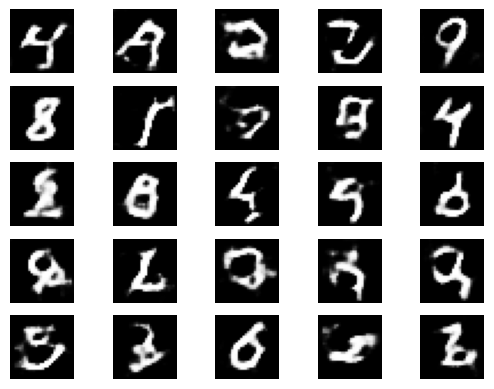

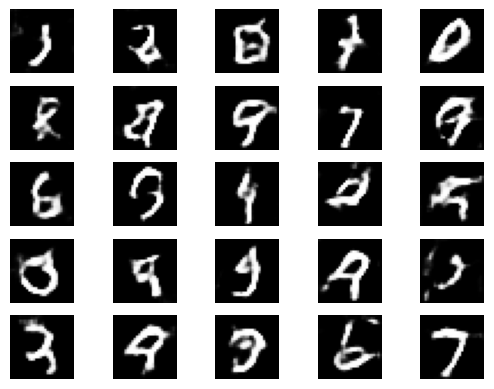

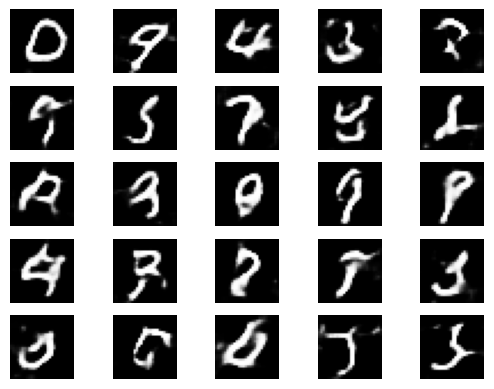

In [22]:
gan_train(4001, 32, 800)